In [73]:
from qutip import *
from sympy import S
# from sympy.physics.wigner import clebsch_gordan 
import numpy as np
from numpy import pi 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Dual Qubit Absorption of One Photon

In their paper "One Photon can Simultaneously Excite Two or More Atoms", Garziano et al. use Qutip to demonstrate that a single photon can be absorbed by two qubits by simulating two qubits in a cavity with a laser drive.  As long as the laser drive frequency is twice the transition frequency between the qubits' ground and excited states.  The purpose of this ipython notebook is to replicate and discuss their results.  

First I define the cavity parameters, and the operators that will be used in the hamiltonian.  I use a 5 dimensional fock space to capture photon behavior.  

In [74]:
#Define cavity parameters
wq = 1 #Hz
wclist = np.linspace(0.75, 2.25, 2000) # wc frequency range
lbda = 0.1*wq #Hz
theta = np.pi/6.
mu = .05
N = 5

# Pre-compute operators for the hamiltonian
a   = tensor(qeye(2), qeye(2), destroy(N))
sz1 = tensor(-1*sigmaz(), qeye(2), qeye(N))
sx1 = tensor(sigmax(), qeye(2), qeye(N))
sz2 = tensor(qeye(2), -1*sigmaz(), qeye(N))
sx2 = tensor(qeye(2), sigmax(), qeye(N))
sm1 = tensor(destroy(2), qeye(2), qeye(N))
sm2 = tensor(qeye(2), destroy(2), qeye(N))

In [80]:
def compute_eigs(wclist, lbda, wq, theta, N, Hcase):  
    idx = 0
    evals_mat = np.zeros((len(wclist),2*2*N))
    for wc in wclist:
        # evaluate the Hamiltonian
        H = 0
        if(Hcase==0):
             H = 0.5*(sz1 + sz2) + wc*a.dag()*a + lbda/wq*(a.dag()+a)*(np.cos(theta)*(sx1 + sx2)+np.sin(theta)*(sz1+sz2))
        if(Hcase==1):
            H0 = 0.5*(sz1 + sz2) + wc*a.dag()*a + lbda/wq*(a.dag()+a)*(np.cos(theta)*(sx1 + sx2)+np.sin(theta)*(sz1+sz2))
            Hk = (1/wq)*mu*a.dag()*a.dag()*a*a
            H = H0+Hk
        evals, ekets = H.eigenstates()
        evals_mat[idx,:] = np.real(evals)
        idx += 1
    return evals_mat, evals, ekets

def compute_freqs(evals_mat):
    w43diff= np.abs(np.subtract(evals_mat[:,4],evals_mat[:,3]))
    w43 = np.amin(w43diff) #frequency splitting
    minindex = np.argmin(w43diff)
    wc43 = wclist[minindex]
    wd = (np.subtract(evals_mat[minindex,4],evals_mat[minindex,0])+np.subtract(evals_mat[minindex,3],evals_mat[minindex,0]))/2
    return w43, wc43, wd

### Eigenvalues and Avoided Crossing

Below I call compute_eigs and compute_freqs using a hamiltonian with counterrotating terms but no Kerr nonlinearity (as used to produce figure 1, in Garziano et al).  

Below, I plot the first nine eigenvalues of the two qubit hamiltonian as a function of normalized cavity frequency. This is figure 2a in Garziano et al.  Uncommenting the commented code will zoom in on the the averted level crossing between $|3\rangle$ and $|4\rangle$, which is figure 2b in Garziano et al. 

The averted crossing of these eigenstates are of interest because it represents hybridization of the states $|g,g,1\rangle$ and $|e,e,0\rangle$, which allows phenomena like the joint absorbtion of one photon by two qubits.

In [ ]:
evals_mat1, evals1, ekets1  = compute_eigs(wclist, lbda, wq, theta, N, 0)
w43_1, wc43_1, wd_1 = compute_freqs(evals_mat1)

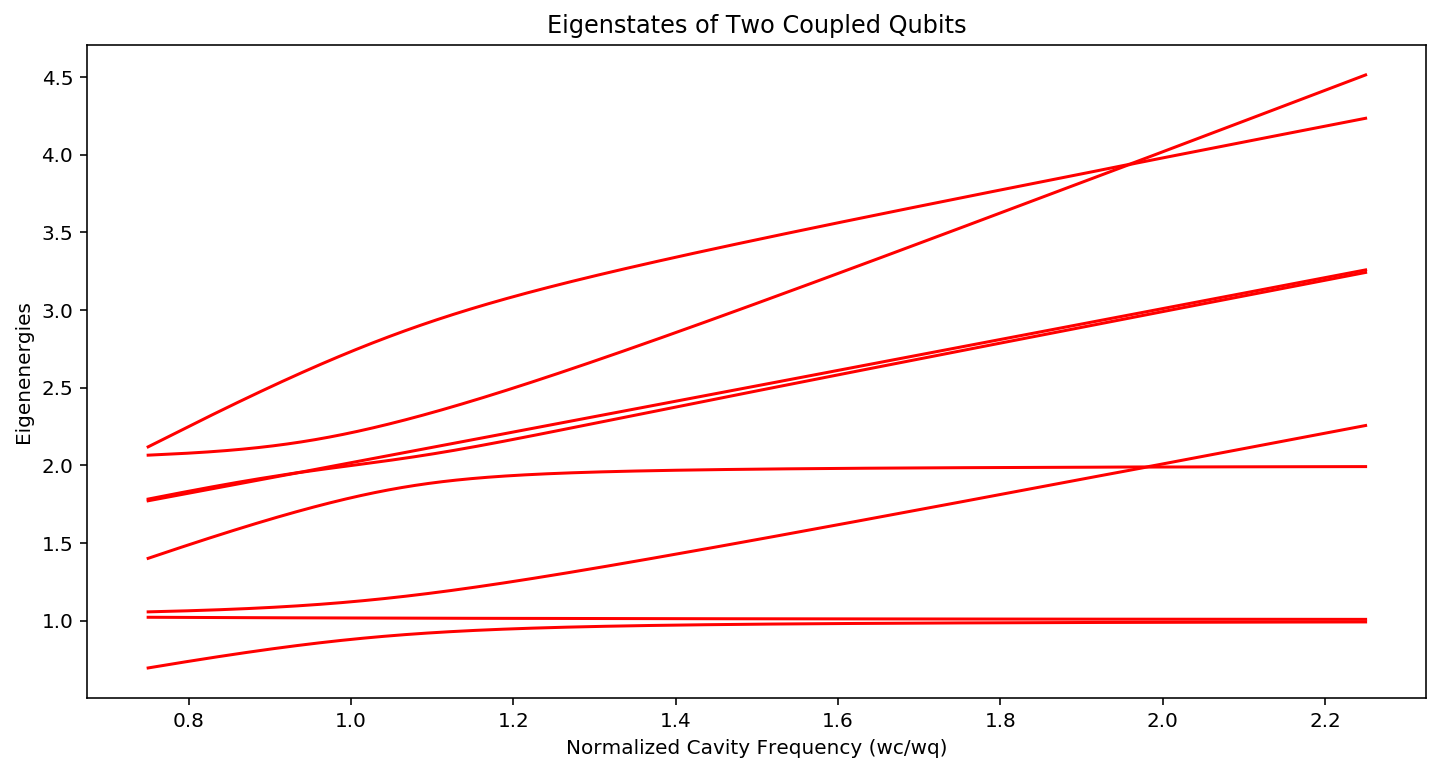

In [95]:
fig, ax = plt.subplots(figsize=(12,6))
for n in range(1,9):
    ax.plot(wclist, (evals_mat1[:,n]-evals_mat1[:,0]) , 'r')
    
#UNCOMMENT FOR FIGURE 2b
#============================
# ax.set_ylim([1.975,2])
# ax.set_xlim([1.965, 1.99])
#============================

ax.set_xlabel('Normalized Cavity Frequency (wc/wq)')
ax.set_ylabel('Eigenenergies')
ax.set_title('Eigenstates of Two Coupled Qubits');

In [87]:
def eps(t, args):
    w43 = args['w43'] 
    wd = args['wd']
    A = args['A']
    tau = 1/(4*w43)
    t_0 = 0
    return A*np.exp(-((t - t_0)**2.0)/(2.0*tau**2.0))/(tau*np.sqrt(2*pi))*np.cos(wd*t)

def xplus(ekets):
    a   = tensor(qeye(2), qeye(2), destroy(N))
    xp = 0
    for i in range(0, len(ekets)):
        for n in range(3,5):
            j = ekets[i]
            k = ekets[n]
            if(n>i):
                xp = xp + (a.dag()+a).matrix_element(j,k)*j*k.dag()
    return xp

def cplus(ekets, sm):
    cp = 0
    for i in range(0, len(ekets)):
        for n in range(0, len(ekets)):
            j = ekets[i]
            k = ekets[n]
            if(n>i):
                cp = cp + (sm+sm.dag()).matrix_element(j,k)*j*k.dag()
    return cp

In [88]:
#calculate mesolve arguments
A = 6

rho0 = tensor(basis(2,0), basis(2,0), fock(N,0))

evals_mat2, evals2, ekets2  = compute_eigs(wclist, lbda, wq, theta, N, 1)

w43, wc43, wd = compute_freqs(evals_mat2)

H0 = 0.5*(sz1 + sz2) + wc43*a.dag()*a + lbda/wq*(a.dag()+a)*(np.cos(theta)*(sx1 + sx2)+np.sin(theta)*(sz1+sz2))
Hk = (1/wq)*mu*a.dag()*a.dag()*a*a

evals3, ekets3 = (H0+Hk).eigenstates() 

cp1 = cplus(ekets3, sm1)
cp2 = cplus(ekets3, sm2)
xp = xplus(ekets3)

omegaeff = w43/2.
tlist = np.linspace(0, 3*np.pi/omegaeff, 2000)


Hd = (1/wq)*(a.dag()+a)
Hsolve = [H0+Hk, [Hd, eps]]
args = {'w43':w43, 'wd':wd, 'A':A}

result = mesolve(Hsolve, rho0, tlist, [], [xp.dag()*xp, cp1.dag()*cp1,cp2.dag()*cp2, cp1.dag()*cp2.dag()*cp2*cp1], args)

### Non-dispersive Time-evolution of a Two Qubit System

Above, I calculate the non-dispersive evolution of the cavity system, using a hamiltonian with a Kerr nonlinearity for the purpose of widening energy level gaps.  


The cavity system is initially excited by a laser pulse with drive frequency $w_d = \frac{w_4+w_3}{2}$. This drives a transition between $|3\rangle$ and $|4\rangle$, that will be visible in the time-dependent solutions for $\langle X^-X^+\rangle$, $\langle C_1^-C_1^+\rangle$, $\langle C_2^-C_2^+\rangle$, which are respectively the expected photon population in the cavity, and the expected excited state populations for qubits 1 and 2.  The values $X^+$ and $C^+$ are defined as follows:

\begin{equation}
X^+ \equiv \sum_{j,k>j} \langle j|(a+a^\dagger)|k \rangle |j\rangle\langle k| 
\end{equation}
\begin{equation}
C^+ \equiv \sum_{j,k>j} \langle j|(\sigma_-+\sigma_+)|k \rangle |j\rangle\langle k|
\end{equation}


The time-evolution of these expectation values is plotted below, along with the two qubit correlation function $\langle C_1^-C_1 C_2^-C_2^+ \rangle$.  The impact of the laser pulse is visible at $t=0$, when the photon population of the cavity is driven to approximately 1. At time $t=\pi/4$ later, the photon has been jointly absorbed by the two qubits, which now both populate their excited states.  

The correlation function $\langle C_1^-C_1 C_2^-C_2^+ \rangle$ overlaps almost perfectly with $\langle C_1^-C_1^+\rangle$ and $\langle C_2^-C_2^+\rangle$, indicating that the qubits are almost perfectly correlated in their behavior. 

For $t>\pi/2$, the two qubits continue to jointly emit and then absorb a single cavity photon. This illustrates the primary phenomena examined by Garziano et al. in their paper, but they go on to model the same behavior in a dispersive cavity.  Results for a dispersive cavity are replicated and discussed below.  

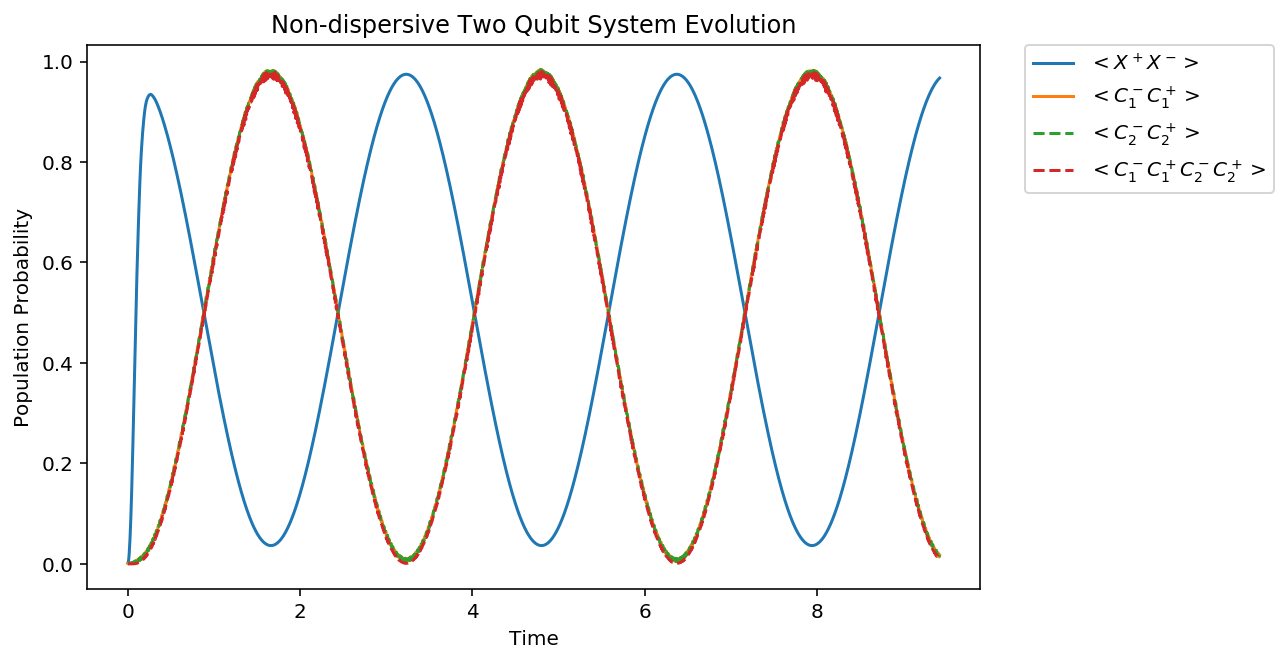

In [94]:
x_expvals = result.expect[0]
c1_expvals = result.expect[1]
c2_expvals = result.expect[2]
corr_expvals = result.expect[3]


#plot the data
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(tlist*omegaeff, x_expvals, label="$<X^+ X^->$")
ax.plot(tlist*omegaeff, c1_expvals, label="$<C_1^- C_1^+>$")
ax.plot(tlist*omegaeff, c2_expvals, '--', label="$<C_2^- C_2^+>$")
ax.plot(tlist*omegaeff, corr_expvals, '--', label="$<C_1^- C_1^+ C_2^-C_2^+>$")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Time');
ax.set_ylabel('Population Probability');
ax.set_title('Non-dispersive Two Qubit System Evolution');

### Dispersive Time-evolution of a Two Qubit System

Below I calculate the time-evolution of the same photon and qubit population operators, but in a dispersive cavity. I use $\kappa$ and $\gamma$ as estimations of the cavity damping rate, and atomic decay rate, respectively. These scalars multiply the collapse operators $X^+$ and $C^+$. 

The result, plotted below, clearly exhibits damping.  As time passes, the qubits become less correlated their excited state population probabilities approaches 0.5.  

In [90]:
kappa = 4e-5
gamma = 4e-5

result_d = mesolve(Hsolve, rho0, tlist, [np.sqrt(kappa)*xp, np.sqrt(gamma)*cp1, np.sqrt(gamma)*cp2], [xp.dag()*xp, cp1.dag()*cp1, cp2.dag()*cp2, cp1.dag()*cp2.dag()*cp2*cp1], args, progress_bar=ui.TextProgressBar())

10.0%. Run time:  38.51s. Est. time left: 00:00:05:46
20.0%. Run time:  83.64s. Est. time left: 00:00:05:34
30.0%. Run time: 129.56s. Est. time left: 00:00:05:02
40.0%. Run time: 194.06s. Est. time left: 00:00:04:51
50.0%. Run time: 260.12s. Est. time left: 00:00:04:20
60.0%. Run time: 324.40s. Est. time left: 00:00:03:36
70.0%. Run time: 388.90s. Est. time left: 00:00:02:46
80.0%. Run time: 451.75s. Est. time left: 00:00:01:52
90.0%. Run time: 514.43s. Est. time left: 00:00:00:57
Total run time: 575.70s


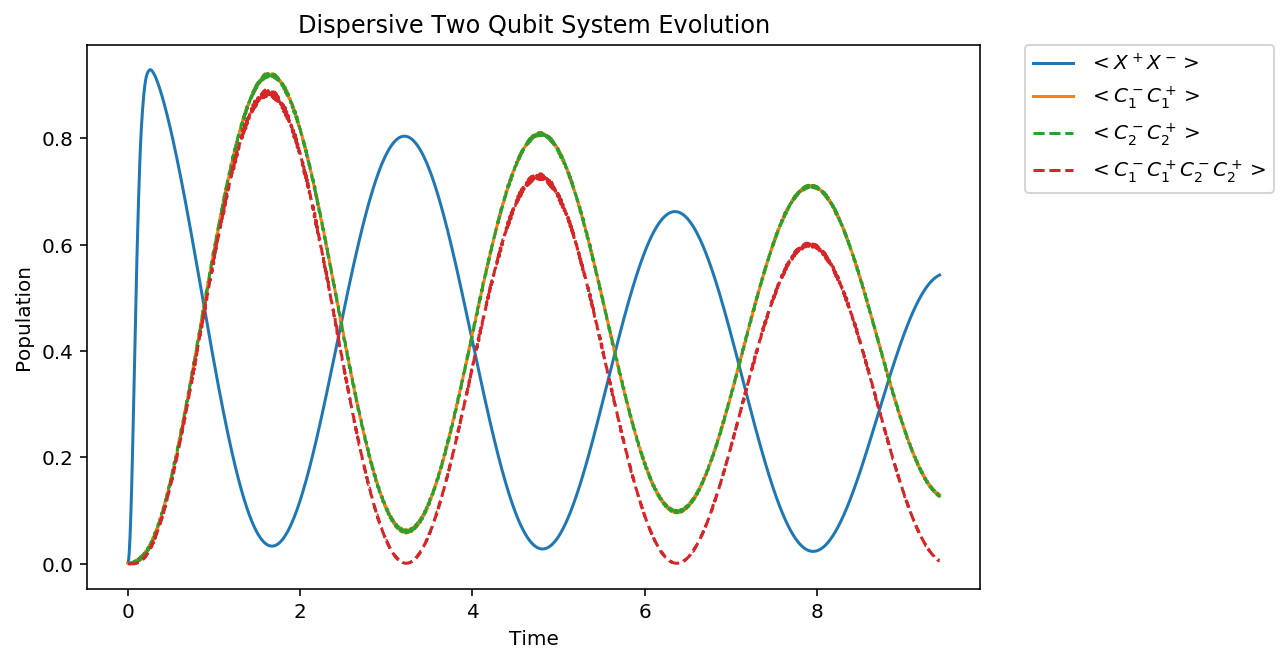

In [98]:
#plot the data
x_expvals_d = result_d.expect[0]
c1_expvals_d = result_d.expect[1]
c2_expvals_d = result_d.expect[2]
corr_expvals_d = result_d.expect[3]

fig,ax=plt.subplots(figsize=(8,5))
ax.plot(tlist*omegaeff, x_expvals_d, label="$<X^+ X^->$")
ax.plot(tlist*omegaeff, c1_expvals_d, label="$<C_1^- C_1^+>$")
ax.plot(tlist*omegaeff, c2_expvals_d, '--', label="$<C_2^- C_2^+>$")
ax.plot(tlist*omegaeff, corr_expvals_d, '--', label="$<C_1^- C_1^+ C_2^-C_2^+>$")

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Time');
ax.set_ylabel('Population');
ax.set_title('Dispersive Two Qubit System Evolution');

### Works Cited:

Garziano, L., Macrì, V., Stassi, R., Stefano, O. D., Nori, F., & Savasta, S. (2016). One Photon Can Simultaneously Excite Two or More Atoms. Physical Review Letters, 117(4). doi:10.1103/physrevlett.117.043601